In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import phoebe as pb
from phoebe import u
import csv
import pandas as pd 

In [2]:
logger = pb.logger()
b = pb.default_binary()

In [3]:
print(pb.__version__)

2.4.10


In [7]:
df = pd.read_csv("./TIC_465088681_sec12.csv", sep="\t")
# df = pd.read_csv("./TIC_465088681_200.csv", sep="\t")

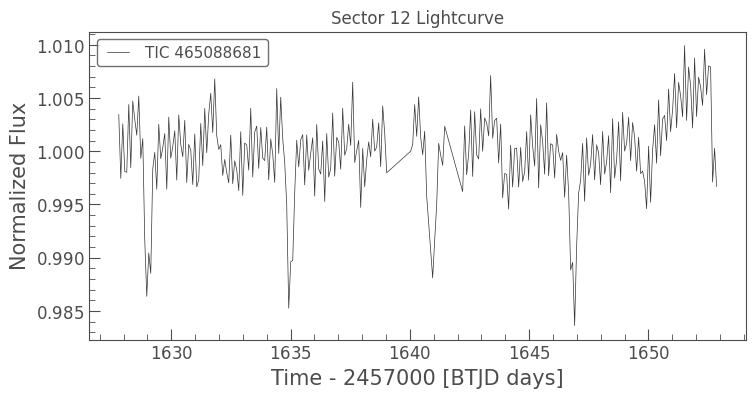

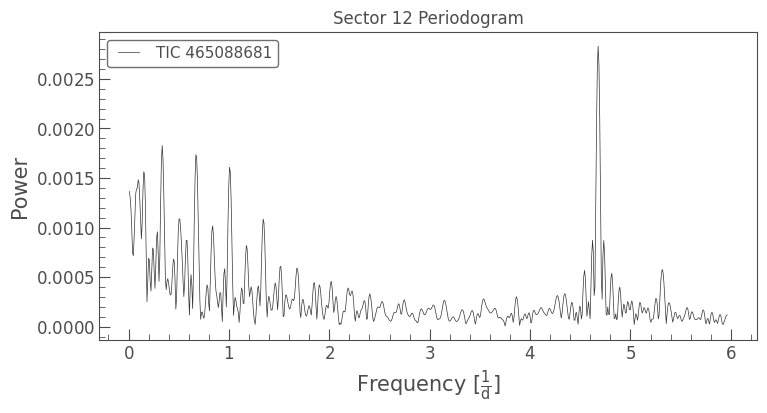

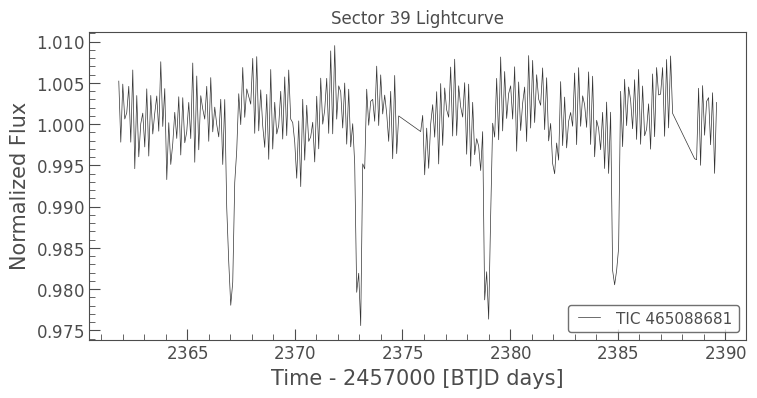

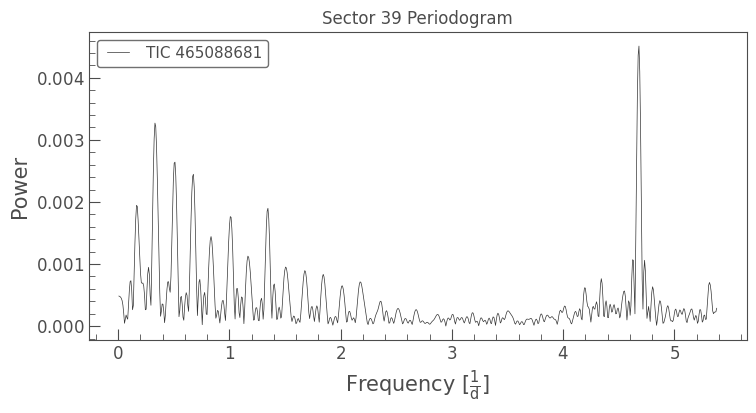

<ParameterSet: 80 parameters | contexts: figure, compute, dataset, constraint>

In [4]:
### loading, flattening, and removing outliers from lightcurve (TESS)
TIC = 'TIC 465088681' #lambda sco
search_data0 = lk.search_lightcurve(TIC)[0]
search_data3 = lk.search_lightcurve(TIC)[3]

lc1 = search_data0.download()
norm_lc1 = lc1.normalize().remove_outliers()
norm_rem1 = norm_lc1.bin(bins=300).remove_nans()
#need 500 data points to make it work, remove nans removes empty bins, 500 is optimal
lc0 = norm_rem1
lc0.plot()
plt.title("Sector 12 Lightcurve")

lombscargle0 = lc0.to_periodogram(method='lombscargle')
lombscargle0.plot()
plt.title("Sector 12 Periodogram")

lc2 = search_data3.download()
norm_lc2 = lc2.normalize().remove_outliers()
norm_rem2 = norm_lc2.bin(bins=300).remove_nans()
lc3 = norm_rem2
lc3.plot()
plt.title("Sector 39 Lightcurve")

lombscargle3 = lc3.to_periodogram(method='lombscargle')
lombscargle3.plot()
plt.title("Sector 39 Periodogram")
plt.show()

### defining units PHOEBE will accept, defining fluxes and times
lc = lc0
watts_units = u.W / (u.m * u.m)
fluxes=lc['flux'] * watts_units
times = lc.time.to_value('btjd')
sigmas = lc['flux_err'] * watts_units
b.add_dataset('lc', fluxes=lc['flux']*watts_units, times=lc.time.to_value('btjd'), sigmas = lc['flux_err']*watts_units)

In [4]:
# flux = df['flux']
watts_units = u.W / (u.m * u.m)
flux =df['flux']
time = df['time']
sigma = df['flux_err']

In [5]:
### adding lightcurve dataset
b.add_dataset('lc', fluxes=flux.values*watts_units, times=time.values*u.day, sigmas = sigma.values*watts_units, overwrite=True)

<ParameterSet: 80 parameters | contexts: figure, dataset, constraint, compute>

In [6]:
#system 
b["ecc@binary"] = 0.26
# b["q@binary"] = 5.77
b["sma@binary"] = 65.5 * u.solRad
b["incl@binary"] = 79.5
b["per0"] = 311 *u.deg
b["period@binary"] = 5.952 *u.day
b.flip_constraint("freq@binary", solve_for="period")
# b.add_dataset('lc', fluxes=flux.values*watts_units, times=time.values*u.day, sigmas = sigma.values*watts_units, overwrite=True)

#primary
b.remove_constraint("mass@primary")
b["mass@primary"] = 10.4
# b["mass@primary"] = 18
b["requiv@primary"] = 12
b["teff@primary"] = 25000
b["gravb_bol@primary"] = 1.0
b["irrad_frac_refl_bol@primary"] = 1.0
b.flip_constraint("logg@primary", solve_for="requiv")
b["logg@primary@star@component"] = 3.8

#secondary
b.remove_constraint("mass@secondary")
b["mass@secondary@component"] = 1.8
b["requiv@secondary@component"] = 2.2
b["teff@secondary@component"] = 7000
b["gravb_bol@secondary"] = 1.0
b["irrad_frac_refl_bol@secondary"] = 1.0

#atmosphere
b.set_value_all("ld_mode", "manual")
b.set_value_all("ld_mode_bol", "manual")
b.set_value_all("atm", "ck2004")
# b.set_value('pblum_mode', 'dataset-scaled')
b.set_value('pblum_mode', 'component-coupled')

100%|█████████████████████████████████████████| 554/554 [00:12<00:00, 44.05it/s]


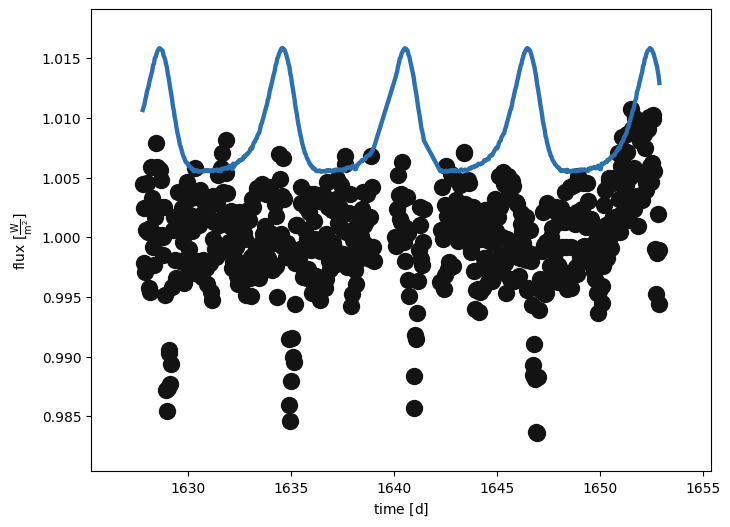

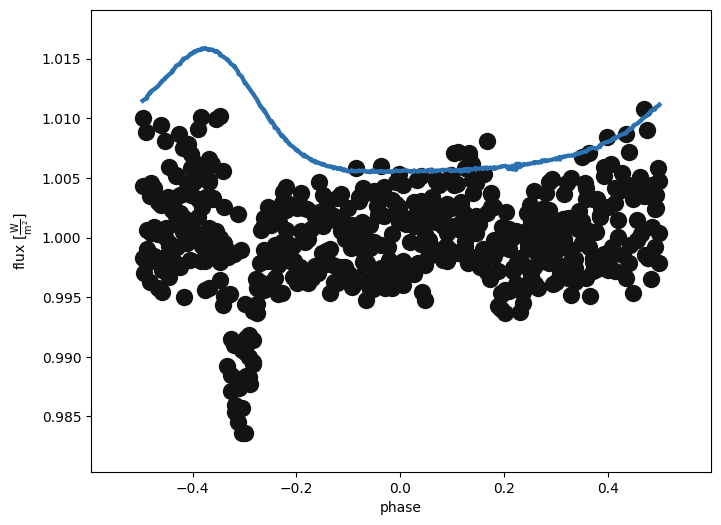

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [8]:
b.run_compute()
b.plot(show=True)
b.plot(x='phase', show=True)
### blue is synthetic, black is data

In [7]:
b.flip_constraint("esinw@binary@orbit", solve_for='ecc')
b.flip_constraint("ecosw@binary@orbit", solve_for='per0')
b.remove_constraint("teffratio@binary@orbit")
b.remove_constraint("requivsumfrac@binary@orbit")

b.add_solver('estimator.ebai', solver='ebaiest', ebai_method = 'mlp', overwrite=True)
b['phase_bin@ebaiest@solver'] = False
b.run_solver(solver='ebaiest', solution= "ebaiest_sol",kind='ebai', overwrite=True)
print(b.adopt_solution('ebaiest_sol'))
b.adopt_solution('ebaiest_sol')

ParameterSet: 20 parameters
      t0_supconj@binary@component: -1.7763863324729934 d
       teffratio@binary@component: 0.8086927508609159
   requivsumfrac@binary@component: 0.22240294819868262
           esinw@binary@component: -0.006271462740427669
           ecosw@binary@component: 0.02603994907811613
            incl@binary@component: 77.52201175914828 deg
C     t0_perpass@binary@component: -3.438705891455844 d
C         t0_ref@binary@component: -7.6788241434738005 d
C     compute_phases@lc01@dataset: []
C    requivratio@binary@component: 0.3272443786437847
C            ecc@binary@component: 0.02678451405001505
C           per0@binary@component: 346.45876524302156 deg
C          asini@binary@component: 63.95283015512402 solRad
C         asini@primary@component: 31.97641507756201 solRad
C          incl@primary@component: 77.52201175914828 deg
C    requiv_max@primary@component: 24.32934298869312 solRad
C       asini@secondary@component: 31.97641507756201 solRad
C        incl@secondar

<ParameterSet: 6 parameters | qualifiers: t0_supconj, teffratio, esinw, requivsumfrac, ecosw, incl>

In [8]:
b["requiv@secondary@component"] = 2.2
b["incl@binary"] = 85
b.flip_constraint("requiv@primary", solve_for="logg")
b["requiv@primary"] = 12 #12
b["teff@secondary@component"] = 7000 #6000
b["teff@primary@component"] = 25000
b["irrad_frac_refl_bol@primary"] = 1.0
b["sma@binary"] = 65.5 * u.solRad
b["incl@binary"] = 79.5 #80

100%|█████████████████████████████████████████| 554/554 [00:13<00:00, 41.99it/s]


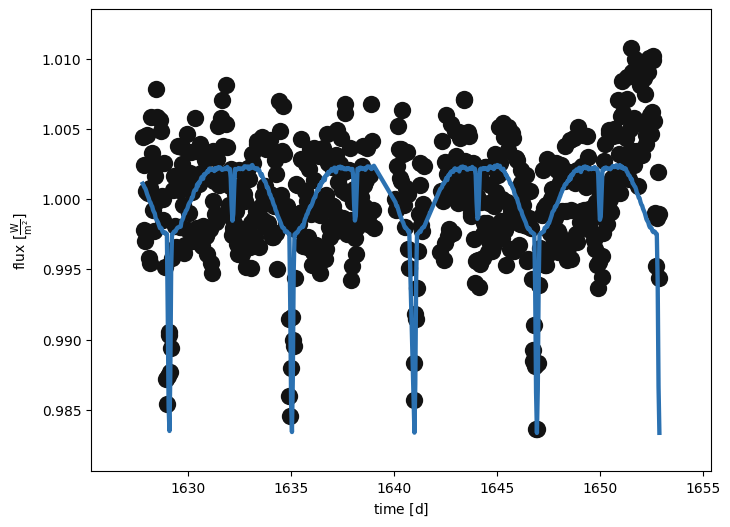

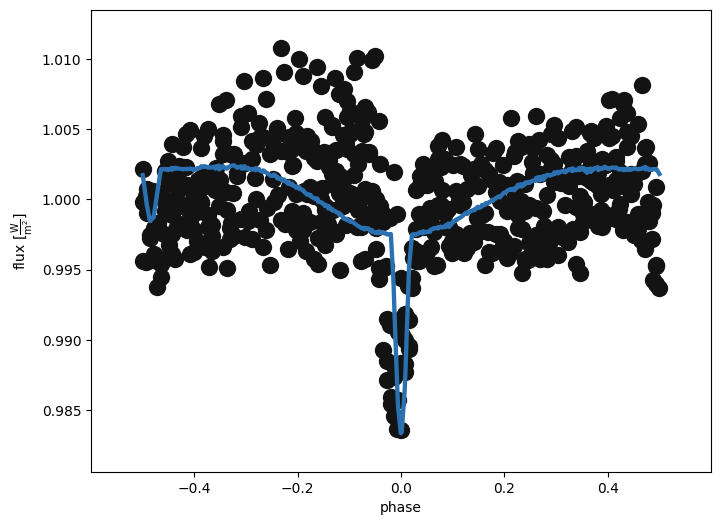

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [9]:
b.run_compute()
b.plot(show=True)
b.plot(x='phase', show=True)

In [10]:
b.add_solver('optimizer.nelder_mead', solver='nm_solver')

<ParameterSet: 14 parameters | qualifiers: priors, comments, continue_from, expose_lnprobabilities, use_server, fit_parameters, xatol, compute, maxiter, adaptive, priors_combine, fatol, progress_every_niters, initial_values>

In [19]:
# print(b.filter(solver='nm_solver'))
b.add_compute('ellc', compute='fastcompute', overwrite=True)
b.set_value('compute', solver='nm_solver', value='fastcompute')
# b.set_value('compute', solver='nm_solver', value='phoebe01')
# ValueError: value for compute@nm_solver@solver must be one of ['phoebe01'], not 'fastcompute'
b.set_value('maxiter', 1000)
# b.set_value('maxfev', 1000)
# print(b.get_parameter('fit_parameters'))

In [13]:
b.set_value('fit_parameters', ['q', 'vgamma', 't0_supconj'])
b.get_value('fit_parameters', expand=True)

['q@binary@orbit@component',
 'vgamma@system',
 't0_supconj@binary@orbit@component']

In [14]:
print(b.filter(qualifier='enabled', compute='phoebe01'))
print(b.filter(qualifier='enabled', compute='fastcompute'))

ParameterSet: 1 parameters
         enabled@phoebe01@compute: True
ParameterSet: 1 parameters
      enabled@fastcompute@compute: True


In [21]:
b.run_solver('nm_solver', solution='nm_sol', overwrite=True)

  4%|█▋                                       | 41/1000 [00:11<05:50,  2.74it/s]/Users/skbowes/anaconda3/lib/python3.10/site-packages/phoebe/frontend/bundle.py:11999: RuntimeWarning: overflow encountered in multiply
  fluxes *= pbfluxes.get(flux_param.dataset)


 starshape: failed to converge : t  =    2.2962842819440610E-006
 End ELLC - error calling starshape


 10%|████                                    | 103/1000 [00:34<05:01,  2.97it/s]


<ParameterSet: 11 parameters | qualifiers: adopt_distributions, comments, adopt_values, adopt_parameters, message, fitted_twigs, fitted_values, fitted_units, initial_values, success, niter>

In [23]:
b.run_compute(compute='fastcompute', sample_from='nm_sol', model='nm_model', overwrite=True)

Thu, 27 Jul 2023 11:26 BUNDLE       WARNING all distributions are delta, using sample_size=1 instead of sample_size=10
100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s]


Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: RemoteDisconnected Remote end closed connection without response


<ParameterSet: 8 parameters | qualifiers: comments, failed_samples, sampled_twigs, samples, times, sampled_uniqueids, fluxes, sample_mode>

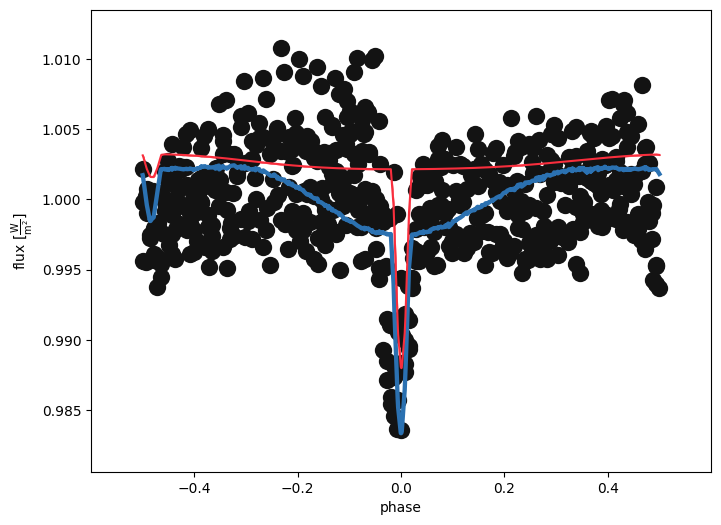

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [24]:
b.plot(x='phases', 
           linestyle={'model': 'solid'},
           color={'nm_model': 'red', 'model_orig': 'green'},
           show=True)

In [21]:
# print(b.filter(solution='nm_sol'))
print(b.adopt_solution(trial_run=True))

ValueError: could not find solution='None'

In [26]:
b.add_solver('sampler.emcee')
b.run_solver(kind='emcee')

Tue, 18 Jul 2023 14:02 BUNDLE       WARNING no valid distributions in init_from  If not addressed, this warning will continue to be raised and will throw an error at run_solver.


ValueError: failed to pass checks
Run Checks Report: FAIL
ERROR: no valid distributions in init_from (3 affected parameters, affecting run_solver)

In [ ]:
b.set_value('pblum', dataset='lc01', component='primary', value=pblums_scaled['pblum@primary@lc01'])
print(b.compute_pblums(compute='fastcompute', dataset='lc01', pbflux=True))

In [11]:
b.add_dataset('orb', compute_times=time.values*u.day)
# b.add_dataset('orb', compute_times=np.linspace(-1,1,1001))
b.run_compute(ltte=False)

Mon, 17 Jul 2023 13:12 BUNDLE       WARNING overwriting model: latest
100%|█████████████████████████████████████████| 554/554 [00:13<00:00, 41.69it/s]


<ParameterSet: 17 parameters | kinds: orb, lc>

In [12]:
print(b.get_parameter('fit_parameters'))

Parameter: fit_parameters@nelder_mead01@solver
                       Qualifier: fit_parameters
                     Description: parameters (as twigs) to optimize
                           Value: []
                         Choices: distance@system, vgamma@system, ebv@system, Av@system, Rv@system, requiv@primary@star@component, requiv_max@primary@star@component, requiv_min@primary@star@component, teff@primary@star@component, abun@primary@star@component, logg@primary@star@component, syncpar@primary@star@component, period@primary@star@component, freq@primary@star@component, pitch@primary@star@component, yaw@primary@star@component, incl@primary@star@component, long_an@primary@star@component, gravb_bol@primary@star@component, irrad_frac_refl_bol@primary@star@component, irrad_frac_lost_bol@primary@star@component, ld_coeffs_bol[0]@primary@star@component, ld_coeffs_bol[1]@primary@star@component, mass@primary@star@component, requiv@secondary@star@component, requiv_max@secondary@star@componen

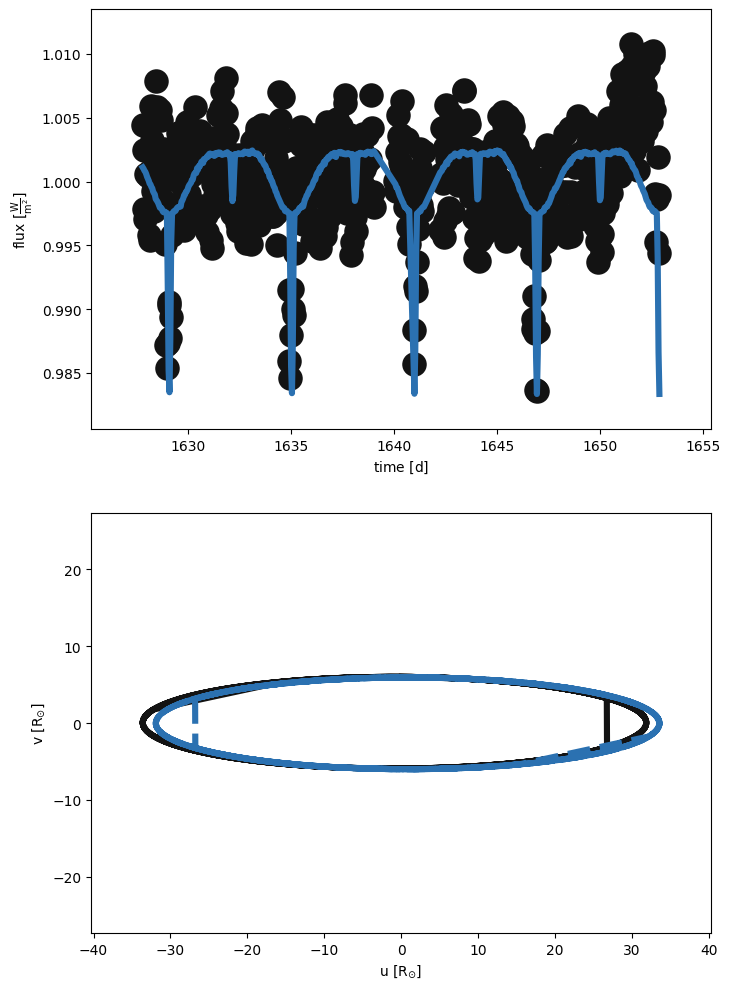

In [14]:
afig, mplfig = b.plot(time='t0_supconj', show=True)

In [31]:
print(b.filter('compute_phases'))

ParameterSet: 4 parameters
C     compute_phases@lc01@dataset: []
   compute_phases@lc01@constraint: times_to_phases({compute_times@lc01@dataset}, {phases_period@lc01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@lc01@dataset}, {dpdt@binary@component}, {phases_t0@lc01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component})
C    compute_phases@orb01@dataset: [-0.2168557  -0.20981663 -0.20277756 ...
 -0.01452998 -0.00749091 -0.00051911]
   compute_phases@orb01@constr...: times_to_phases({compute_times@orb01@dataset}, {phases_period@orb01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@orb01@dataset}, {dpdt@binary@component}, {phases_t0@orb01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component})


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

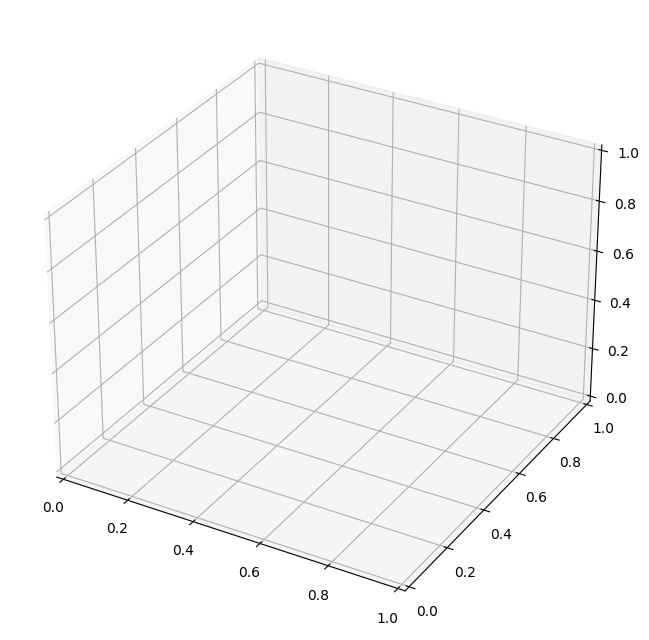

In [15]:
afig, mplfig = b.plot(projection='3d', show=True)

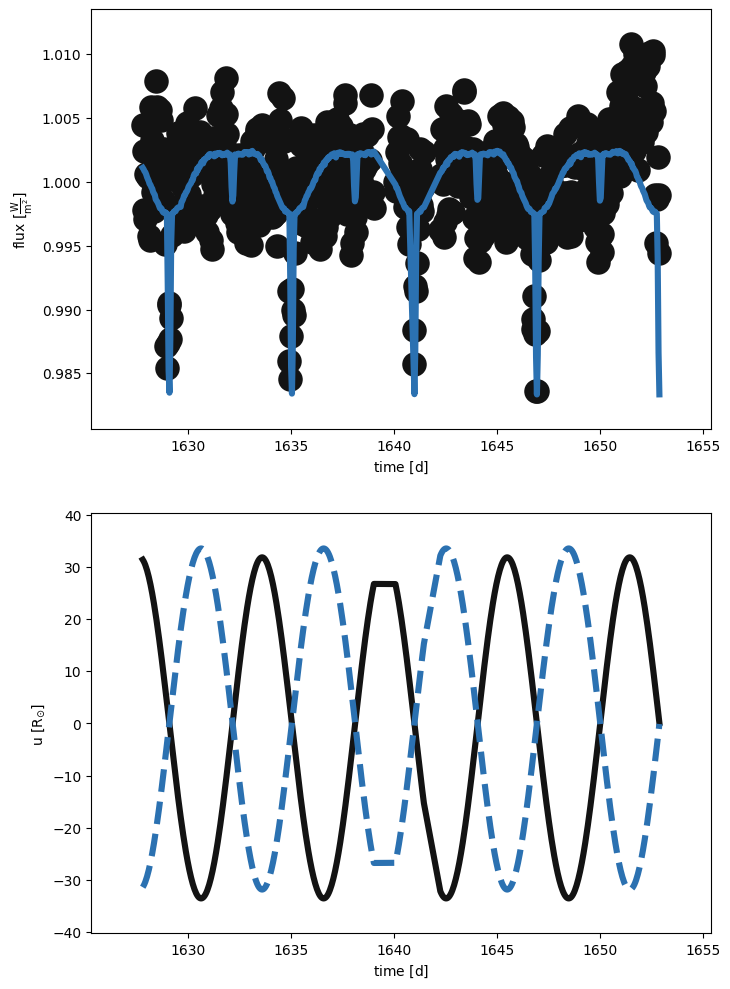

In [16]:
afig, mplfig = b.plot(x='times', show=True)
# u is a position on the sky

In [25]:
print(b.get_parameter(qualifier='us', component='primary', kind='orb', context='model'))

Parameter: us@primary@latest@model
                       Qualifier: us
                     Description: U position
                           Value: [31.44358646 31.16441817 30.81966455 ...  2.9681394   1.53176243
  0.10618675] solRad
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [12]:
axs, artists = b.plot()

In [13]:
b.add_dataset('mesh', include_times= 'lc01')

<ParameterSet: 85 parameters | contexts: dataset, compute, figure, constraint>

In [14]:
b.set_value('compute_times', kind='mesh', value=[10])
b.set_value('include_times', kind='mesh', value=['lc01'])
b.set_value('columns', value=['teffs'])
b.run_compute()
# afig, mplfig = b.plot(kind='mesh', time=0.0, fc='teffs', ec='none', show=True)

Mon, 17 Jul 2023 13:13 BUNDLE       WARNING overwriting model: latest
100%|█████████████████████████████████████████| 555/555 [00:13<00:00, 41.32it/s]


KeyboardInterrupt: 

In [ ]:
#will generate figure without time, but nothing gets plotted.
afig, mplfig = b.plot(kind='mesh', time=, fc='teffs', ec='none', show=True)

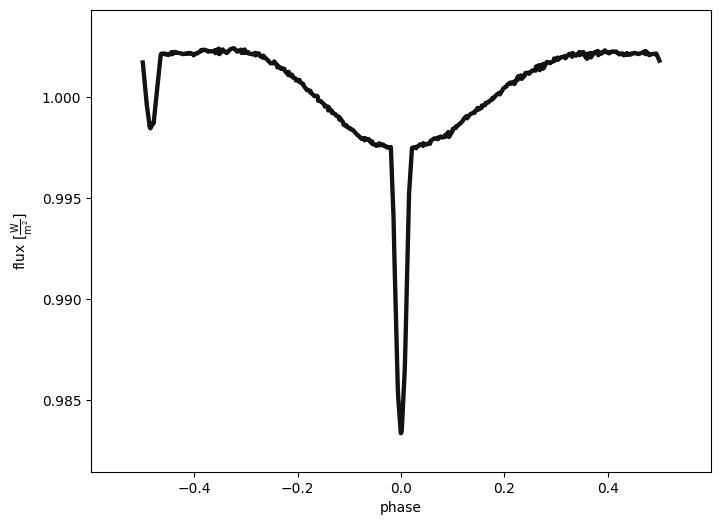

In [20]:
afig, mplfig = b['lc01@model'].plot(x='phases', t0='t0_supconj', show=True)

In [11]:
b.add_solver('optimizer.nelder_mead')
print(b.run_checks())
b.run_solver(kind='nelder_mead')
# print run checks, see which parameters are failing

Fri, 30 Jun 2023 14:34 BUNDLE       WARNING no valid parameters in fit_parameters  If not addressed, this warning will continue to be raised and will throw an error at run_solver.


Run Checks Report: FAIL
ERROR: no valid parameters in fit_parameters (2 affected parameters, affecting run_solver)


ValueError: failed to pass checks
Run Checks Report: FAIL
ERROR: no valid parameters in fit_parameters (3 affected parameters, affecting run_solver)

In [12]:
b.add_solver('estimator.ebai', solver='ebaiknn', ebai_method = 'knn', overwrite=True)
b['phase_bin@ebaiknn@solver'] = False
b.run_checks()
b.run_solver(solver='ebaiknn', solution= "ebaiknn_sol", kind='ebai', overwrite=True)
print(b.adopt_solution('ebaiknn_sol'))
b.adopt_solution('ebaiknn_sol')

Fri, 30 Jun 2023 14:34 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Fri, 30 Jun 2023 14:34 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.
/Users/skbowes/anaconda3/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/skbowes/anaconda3/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For 

AttributeError: 'NoneType' object has no attribute 'shape'

In [13]:
b.flip_constraint("ecc@binary@orbit", solve_for='esinw')
b.flip_constraint("per0@binary@orbit", solve_for='ecosw')

b.add_solver('estimator.lc_geometry', solver= 'lc_geo', overwrite=True)
# b['analytical_model@lc_geo'] = 'two-gaussian' ##this throws up an error, requires additional arguments
b['analytical_model@lc_geo'] = 'polyfit'
# print(b.get_solver(solver='lc_geo'))
print(b.run_checks())
b.run_solver(solver = 'lc_geo', solution = 'lc_geo_sol', kind='lc_geometry', overwrite=True)
b.adopt_solution('lc_geo_sol')

Fri, 30 Jun 2023 14:43 SOLVER       WARNING binning input observations (len: 554) with 500 bins (ignores sigmas)
Fri, 30 Jun 2023 14:43 SOLVER       WARNING phase-binning resulted in bin(s) with <=1 entries, ignoring sigmas as cannot determine per-bin sigmas.


Run Checks Report: FAIL
ERROR: no valid parameters in fit_parameters (2 affected parameters, affecting run_solver)
ERROR: esinw@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (ecc@binary@orbit@component, per0@binary@orbit@component).  Flip the constraint manually first, set adopt_values=False, or remove esinw@binary@orbit@component from adopt_parameters. (4 affected parameters, affecting adopt_solution)
ERROR: ecosw@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (ecc@binary@orbit@component, per0@binary@orbit@component).  Flip the constraint manually first, set adopt_values=False, or remove ecosw@binary@orbit@component from adopt_parameters. (4 affected parameters, affecting adopt_solution)


<ParameterSet: 14 parameters | contexts: component, dataset>

In [ ]:
b.add_solver('estimator.lc_periodogram', solver= 'lc_periodo', overwrite=True)
b.run_solver(solver= 'lc_periodo', solution = 'periodo_sol', kind='lc_periodogram', overwrite=True)
print(b.adopt_solution('periodo_sol'))
b.adopt_solution('periodo_sol')

b.run_compute()
b.plot(show=True)
b.plot(x='phase', show=True)

In [ ]:
# b.filter(component='primary', context='constraint')
print(b.filter(qualifier='atm'))
# b.set_value("logg@secondary@component", value = 3.4)
print(b.get_parameter('atm@primary@phoebe01@phoebe@compute'))
# print(b.get_parameter('q@binary@component'))

In [ ]:
""" set values """
# teff, requiv at prim or sec
# sma, period

b.set_value("teff@primary@component", value=25000)
# b.flip_constraint("teffratio@binary", solve_for = "teff@secondary")
# b.flip_constraint("teff@primary", solve_for = "teff@secondary")
b.set_value('ecc@binary@orbit@component', value=0.26)
b.set_value("teffratio@binary@component", value = 8.8)
# b.flip_constraint('teffratio@binary@component', solve_for='teff@primary')

# b.set_value("requiv@primary@component", value = 8.8)
# b.remove_constraint()
# b.set_value("teff@secondary@component", value=7000)

b.set_value("q@binary", value = 8.8)
b.set_value("sma@binary", value = 8.8)
b.set_value("per0@primary@component", value = 60)

### dont flip for teff ratio, try without flipping
 
# b.flip_constraint('requivsumfrac@binary@orbit', solve_for='sma')

""" we were here! try to get this running, with logg set (so it must be flipped)"""
b.flip_constraint('logg@primary', solve_for="requiv@primary") #its been flipped!
b.set_value("logg@primary@component", value = 3.8)

In [ ]:
print(b.filter(context='component'))
# mass @ binary, solve for q @ binary
#inclination , effective t, r equiv all have a big effect, so does sma

In [ ]:
### from the phoebe demos
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('atm', 'blackbody')

b.flip_constraint('requivsumfrac', solve_for='requiv@secondary')
b.flip_constraint('teffratio@binary', solve_for='teff@secondary')
b.flip_constraint("esinw@binary@orbit", solve_for='ecc')
b.flip_constraint("ecosw@binary@orbit", solve_for='per0')

In [ ]:
### only works AFTER lc periodogram
b.add_solver('estimator.ebai', solver='ebaiest', ebai_method = 'mlp', overwrite=True)
b['phase_bin@ebaiest@solver'] = False
# print(b['ebaiest'])
#mlp
b.run_solver(solver='ebaiest', solution= "ebaiest_sol",kind='ebai', overwrite=True)

### flip back to default for lc estimator ?
# print(b['ebaiest'])

### adopt
b.adopt_solution('ebaiest_sol')

In [ ]:
#this one works!
b.add_solver('estimator.lc_periodogram', solver= 'lc_periodo', overwrite=True)
b.run_solver(solver= 'lc_periodo', solution = 'periodo_sol', kind='lc_periodogram', overwrite=True)
# print(b.get_solution('periodo_sol'))
b.adopt_solution('periodo_sol')

In [ ]:
print(b.get_solution('ebaiest_sol'))

In [ ]:
### add and run
# b.flip_constraint("ecc", solve_for='esinw@binary@orbit')
# b.flip_constraint("per0", solve_for='ecosw@binary@orbit')

b.set_value_all('ld_mode', 'lookup')
b.set_value_all('ld_mode_bol', 'lookup')
b['atm@secondary@compute'] = 'ck2004'
b['atm@primary@compute'] = 'ck2004'
b.set_value('pblum_mode', 'decoupled') #check the default is decoupled

b.add_solver('estimator.lc_geometry', solver= 'lc_geo', overwrite=True)
# b['analytical_model@lc_geo'] = 'two-gaussian' ##this throws up an error, requires additional arguments
b['analytical_model@lc_geo'] = 'polyfit'
print(b.get_parameter('requivsumfrac@binary@orbit@component'))
# print(b.get_solver(solver='lc_geo'))
print(b.run_checks())
b.run_solver(solver = 'lc_geo', solution = 'lc_geo_sol', kind='lc_geometry', overwrite=True)

### see if flipping should go here
# b.flip_constraint('requivsumfrac@binary@orbit', solve_for='sma') #its been flipped
# b.flip_constraint('requiv@primary@star', solve_for='logg') #its been flipped
#try mass flip q

#### adopt
b.adopt_solution('lc_geo_sol')

In [ ]:
b.run_compute()

In [ ]:
b.plot(show=True)
b.plot(x='phase', show=True)

In [ ]:
# b.flip_constraint("ecc", solve_for='esinw@binary@orbit')
# b.flip_constraint("per0", solve_for='ecosw@binary@orbit')

In [ ]:
print(b.filter(component='primary', context='component'))

In [ ]:
### treats sun as a blackbody
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')
b['atm@secondary@compute'] = 'blackbody'
b['atm@primary@compute'] = 'blackbody'
b.set_value('pblum_mode', 'dataset-scaled')

### resets
b.set_value_all('ld_mode', 'lookup')
b.set_value_all('ld_mode_bol', 'lookup')
b['atm@secondary@compute'] = 'ck2004'
b['atm@primary@compute'] = 'ck2004'
b.set_value('pblum_mode', 'decoupled') #check the default is decoupled

### WARNING Atmosphere parameters out of bounds: ldatm=ck2004, teff=[7339.76135311], logg=[7.34496037], abun=[0.]
### mass@primary@component: 807.0356768836715 solMass
### expected logg = 3-4, high 3 to low 4

In [ ]:
# print(b.filter())
# print(b.get_parameter('ld_mode_bol@primary', context='component'))
# print(b.get_parameter('atm@secondary', context='compute'))
# print(b.get_parameter('pblum_mode', context='dataset'))
# b.filter(context='system')

In [ ]:
# print(b.get_value('teffratio@binary@orbit@component'))
# print(b.get_parameter('teffratio@binary@orbit@component'))
# print(b.get_parameter('teffratio@binary@orbit@constraint'))
# b.flip_constraint('teffratio@binary@orbit', solve_for='teff@primary') seconda

# print(b.get_value('requivsumfrac@binary@orbit@component'))
# print(b.get_parameter('requivsumfrac@binary@orbit@component'))
# # print(b.get_parameter('requivsumfrac@binary@orbit@constraint'))
# # b.flip_constraint('requivsumfrac@binary@orbit', solve_for='sma')

# b.add_solver('estimator.rv_geometry', solver='rv_geo', overwrite=True)
# print(b.filter(solver='rv_geo_sol'))
# b.run_solver('rv_geo', solution='rv_geo_sol')
# # print(b.filter(solution='rv_geo_sol'))

# pb.list_available_solvers(devel=False)

In [ ]:
### for primary = A, secondary = B
# b.flip_constraint('logg@secondary', solve_for="requiv@secondary")
# b.set_value("logg@secondary@component", value = 4.0)
b.set_value('q@binary@component', value = 10.4)
b.flip_constraint("mass@primary", solve_for="q@binary")
# b.flip_constraint("mass@secondary", solve_for="q@binary")
b.set_value('mass@secondary@component', value = 8.1)

In [ ]:
#set values before you run the solver
b.run_compute()
# ERROR: constraints ['logg@primary@star@constraint'] failed to run.  Address errors and try again.  Call run_failed_constraints to see the tracebacks. (1 affected parameters, affecting system,run_compute)

In [ ]:
bls = lc.to_periodogram(method='bls')
bls.plot()
# peaks near 0.5
binned_periodo = bls.bin()

print(lombscargle.show_properties())
print(bls.show_properties())